In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
# %pip install tableone
df = pd.read_csv('../rotterdam.csv')

In [14]:
df['er_cat'] = np.where(df['er'] >= 10, 1, 0)
df['pgr_cat'] = np.where(df['pgr'] >= 10, 1, 0)

node_bins = [-0.1, 0, 3, 9, np.inf]
node_labels = ['0', '1-3', '4-9', '10+']
df['nodes_cat'] = pd.cut(df['nodes'], bins=node_bins, labels=node_labels, right=True)

nodes_ord_map = {'0': 0, '1-3': 1, '4-9': 2, '10+': 3}
df['nodes_ord'] = df['nodes_cat'].map(nodes_ord_map)

size_map = {'<=20': 0, '20-50': 1, '>50': 2}
df['size_ord'] = df['size'].map(size_map)

age_bins = [0, 39, 49, 59, 69, np.inf]
age_labels = [0, 1, 2, 3, 4]
df['age_bin'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True).astype(int)

num_features = ['grade', 'age']
cat_features = ['er_cat', 'pgr_cat', 'chemo', 'meno', 'size_ord', 'nodes_cat']

df_clean = df.copy()

In [15]:
colors = ["#0d9634", "#bc38b1"]

In [16]:
from tableone import TableOne

table1 = TableOne(df_clean, columns=num_features + cat_features, groupby='hormon', pval=True)
print(table1)

                     Grouped by hormon                                              
                               Missing      Overall            0           1 P-Value
n                                              2982         2643         339        
grade, n (%)     2                       794 (26.6)   735 (27.8)   59 (17.4)  <0.001
                 3                      2188 (73.4)  1908 (72.2)  280 (82.6)        
age, mean (SD)                       0  55.1 (13.0)  54.1 (13.0)  62.5 (9.9)  <0.001
er_cat, n (%)    0                       704 (23.6)   630 (23.8)   74 (21.8)   0.452
                 1                      2278 (76.4)  2013 (76.2)  265 (78.2)        
pgr_cat, n (%)   0                       951 (31.9)   814 (30.8)  137 (40.4)  <0.001
                 1                      2031 (68.1)  1829 (69.2)  202 (59.6)        
chemo, n (%)     0                      2402 (80.5)  2091 (79.1)  311 (91.7)  <0.001
                 1                       580 (19.5)   552 (20.9) 

c:\Users\ricca\Health Informatics repo\.venv\Lib\site-packages\tableone\formatting.py:177: UserWarning: Order variable not found: nodes_ord
  warnings.warn(f"Order variable not found: {k}")


<Axes: xlabel='hormon'>

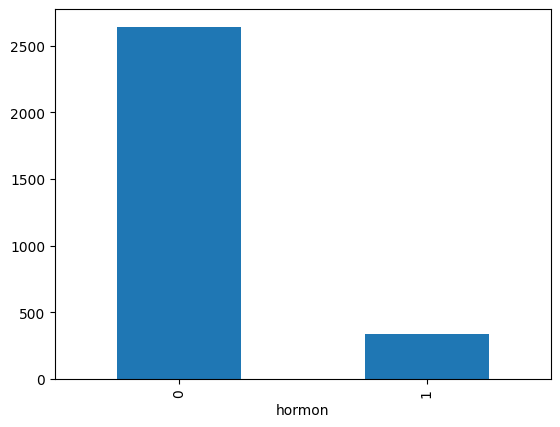

In [17]:
df["hormon"].value_counts().plot(kind="bar")

Hormonal therapy is more frequently administered to patients with higher tumor grade, larger tumor size, greater nodal involvement, and hormone receptor positivity, and is less common among those receiving chemotherapy. Overall, these patterns confirm substantial baseline differences between treatment groups, consistent with confounding by indication.

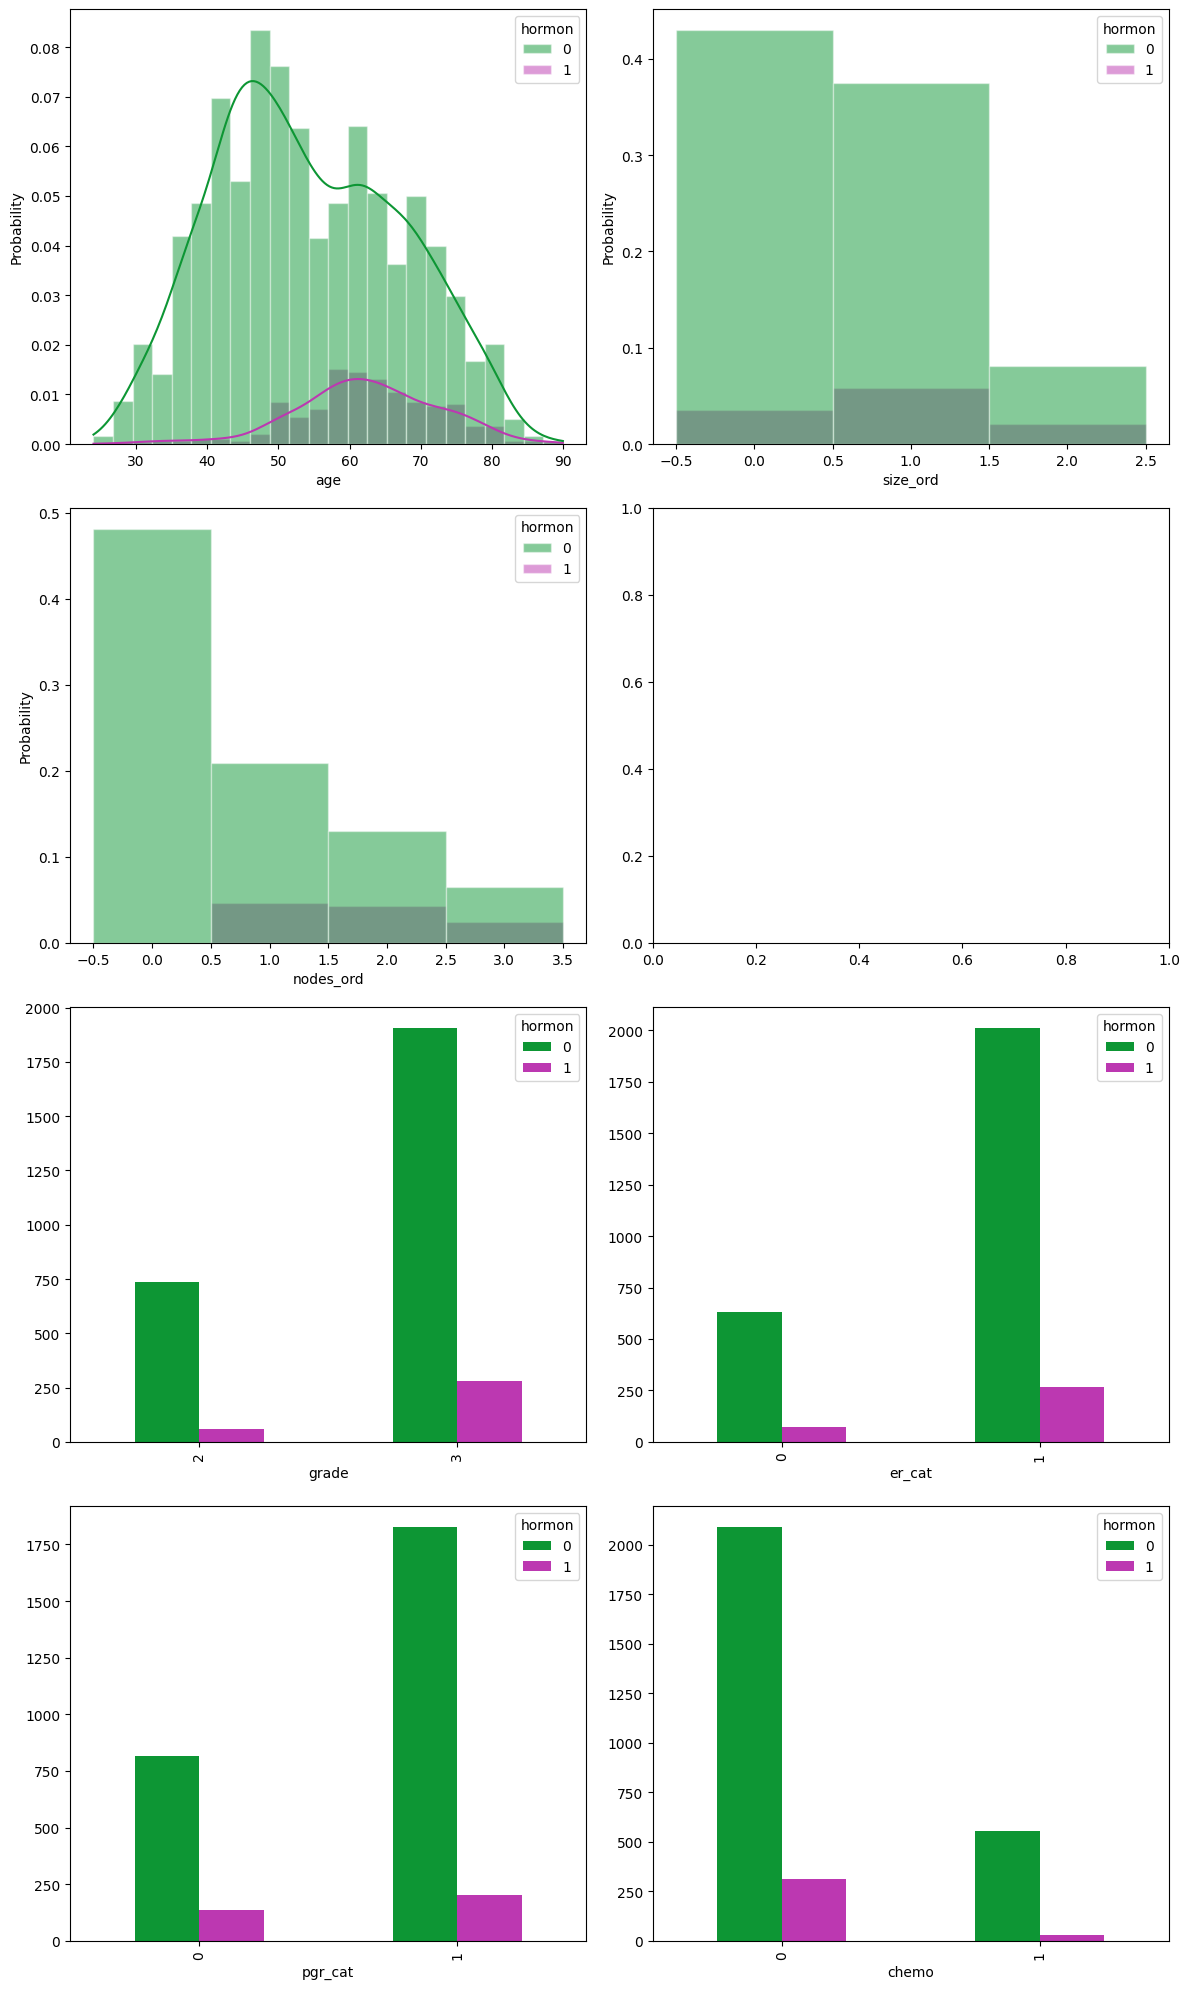

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 20))
axes = axes.flatten()

cat_specs = [
  ("grade", "Grade"),
  ("er_cat", "Estrogen Receptor Status"),
  ("pgr_cat", "Progesterone Receptor Status"),
  ("chemo", "Chemotherapy Received"),
  ("meno", "Menopausal Status"),
]

hist_specs = [
  ("age", "Age", True, False),
  ("size_ord", "Tumor Size", False, True),
  ("nodes_ord", "Number of Positive Nodes", False, True),
]

for ax, (col, _) in zip(axes[4:], cat_specs):
  pd.crosstab(df_clean[col], df_clean["hormon"]).plot(
    kind="bar", stacked=False, ax=ax, color=colors
  )
  
for ax, (col, _, kde, discrete) in zip(axes[:4], hist_specs):
  sns.histplot(
    data=df_clean, x=col, hue="hormon", kde=kde, discrete=discrete,
    edgecolor=(1, 1, 1, .4), stat="probability",
    ax=ax, palette=colors
  )

plt.tight_layout()
plt.show()


## Welch's t-test age in hormonal-therapy-treated patients

A Welch’s t-test is used to compare variables between patients treated and not treated with hormonal therapy, allowing for unequal variances. The resulting p-value assesses whether the age difference between groups is statistically significant.

In [19]:
from scipy.stats import ttest_ind

features_for_ttest = ['er_cat', 'pgr_cat', 'chemo', 'meno', 'size_ord', 'nodes_cat', 'age_bin']

for col in df_clean.columns:
    if df_clean[col].dtype == "object" or str(df_clean[col].dtype) == "category":
        df_clean[col] = df_clean[col].astype("category").cat.codes

results = []
for feature in features_for_ttest:
    group_1 = df_clean.loc[df_clean["hormon"] == 1, feature].dropna()
    group_0 = df_clean.loc[df_clean["hormon"] == 0, feature].dropna()
    t_stat, p_val = ttest_ind(group_1, group_0, equal_var=False)
    results.append({"feature": feature, "t_stat": t_stat, "p_val": p_val})

ttest_results = pd.DataFrame(results).sort_values("p_val")
ttest_results

,feature,t_stat,p_val
5,nodes_cat,23.095248,3.832803e-80
3,meno,17.797613,1.376536e-56
6,age_bin,14.492737,4.027498e-40
2,chemo,-7.456343,3.503248e-13
4,size_ord,6.889671,2.067029e-11
1,pgr_cat,-3.413997,7.026573e-04
0,er_cat,0.838291,4.023275e-01


## Chi-Square test between categorical variables and hormonal therapy

In [20]:
from scipy.stats import chi2_contingency

significant_features = []
not_significant_features = []

for i in cat_features:
    cont_table = pd.crosstab(df_clean[i], df_clean["hormon"])
    chi2, p, dof, expected = chi2_contingency(cont_table)
    if p < 0.05:
        significant_features.append(i)
    else:
        not_significant_features.append(i)
        
print("Significant features:", significant_features)
print("Not significant features:", not_significant_features)

Significant features: ['pgr_cat', 'chemo', 'meno', 'size_ord', 'nodes_cat']
Not significant features: ['er_cat']


In [21]:
dfc = df_clean[['er_cat', 'pgr_cat', 'chemo', 'size', 'nodes_cat', 'age_bin', 'hormon', 'grade']].copy()

In [22]:
print("BEFORE (counts):")
print(dfc["hormon"].value_counts())

# Remove patients who received both chemo and hormon therapy
dfc = dfc[~((dfc["chemo"] == 1) & (dfc["hormon"] == 1))].copy()

print("AFTER (counts):")
print(dfc["hormon"].value_counts())

BEFORE (counts):
hormon
0    2643
1     339
Name: count, dtype: int64
AFTER (counts):
hormon
0    2643
1     311
Name: count, dtype: int64


In [23]:
confounders = ['age_bin', 'nodes_cat', 'grade', 'size', 'er_cat', 'pgr_cat']

# Ensure df_match contains all necessary columns and is a DataFrame
df_match = dfc[confounders + ['hormon']].copy()
# It's good practice to drop rows with NaN values in confounders before matching
df_match = df_match.dropna(subset=confounders + ['hormon'])

Propensity score matching was chosen because the primary estimand of interest is the Average Treatment Effect on the Treated (ATT). Matching naturally targets the ATT by constructing a credible counterfactual for treated patients within the region of common support. In this observational setting, treatment assignment is highly non-random and not all patients are eligible for hormonal therapy, leading to confounding by indication and limited overlap. Compared to IPTW, which is more suitable for estimating the ATE and relies on stronger modeling assumptions, matching provides a more robust and clinically interpretable estimate of the treatment effect in the treated population.

In [24]:
num_vars = ['age_bin', 'grade']
cat_vars = ['nodes_cat', 'pgr_cat', 'er_cat', 'size']

# one-hot encoding of categorical features
df_match_enc = pd.concat([
    df_match.drop(columns=cat_vars),
    pd.get_dummies(df_match[cat_vars], columns=cat_vars, drop_first=True).astype(int)
], axis=1)

In [25]:
T = 'hormon'
X = df_match_enc.columns.drop([T])

# Standardize numerical variables
scaler = StandardScaler()
df_match_enc[num_vars] = scaler.fit_transform(df_match_enc[num_vars])

# Fit the logistic regression model
ps_model = LogisticRegression(C=1e6).fit(df_match_enc[X], df_match_enc[T])

# Add propensity scores to the dataset
data_ps = dfc.assign(propensity_score=ps_model.predict_proba(df_match_enc[X])[:, 1])
data_ps

,er_cat,pgr_cat,chemo,size,nodes_cat,age_bin,hormon,grade,propensity_score
0,1,1,0,1,0,4,0,3,0.000019
1,1,1,0,0,0,4,0,3,0.000015
2,0,1,0,1,0,1,0,2,0.000001
3,1,0,0,0,0,4,0,3,0.000030
4,1,1,0,1,0,4,0,3,0.000019
...,...,...,...,...,...,...,...,...,...
2977,1,1,0,0,1,4,0,3,0.351707
2978,1,0,0,2,3,4,1,3,0.608170
2979,1,1,0,0,2,4,0,3,0.423198
2980,1,0,0,1,0,4,0,3,0.000037


Covariates are standardized and used in a logistic regression model to estimate each patient’s probability of receiving hormonal therapy. The resulting propensity scores are then added to the dataset to support subsequent marching.

In [26]:
data_ps['propensity_score'].describe()

count    2.954000e+03
mean     1.053284e-01
std      1.448049e-01
min      4.508494e-07
25%      4.796173e-06
50%      3.270987e-02
75%      1.764190e-01
max      6.392938e-01
Name: propensity_score, dtype: float64

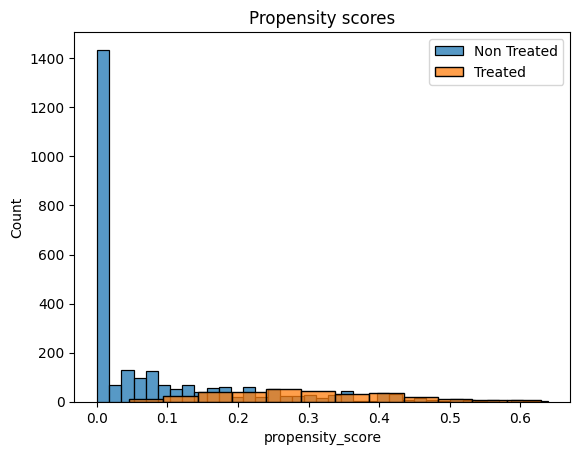

In [ ]:
sns.histplot(data_ps.query("hormon==0")["propensity_score"], kde=False, label="Not treated")
sns.histplot(data_ps.query("hormon==1")["propensity_score"], kde=False, label="Treated")
plt.title("Propensity scores")
plt.legend()